In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner
from psiam_tied_dv_map_utils import up_RTs_fit_single_t_fn, down_RTs_fit_single_t_fn
from psiam_tied_no_dv_map_utils import rho_A_t_fn, all_RTs_fit_single_t_fn
from scipy.integrate import quad

from psiam_tied_dv_map_utils import psiam_tied_data_gen_wrapper

In [2]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

In [3]:
# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [4]:
# LED off rows
df_1 = df[ df['LED_trial'] == 0 ]
# animal rows
animal = 100
df_1 = df_1[ df_1['animal'] == animal ]
print(f' len of df_1 {len(df_1)}')

 len of df_1 6227


# VBMC

## trunc factor

In [5]:
T_trunc = 0.3

## loglike fn

In [6]:
def compute_loglike(row, V_A, theta_A, rate_lambda, T_0, theta_E, t_A_aff, t_E_aff, t_motor, Z_E, L):
    timed_fix = row['timed_fix']
    intended_fix = row['intended_fix']

    is_abort =  timed_fix < intended_fix 
    
    ILD = row['ILD']
    ABL = row['ABL']
    choice = row['response_poke']
    rt = timed_fix
    t_stim = intended_fix

    K_max = 10

    # change T0 units back to seconds from ms
    T_0 *= 1e-3 

    trunc_factor = 1 / (1 - quad(all_RTs_fit_single_t_fn, 0, T_trunc, args=(V_A, theta_A, \
                                                                            ABL, ILD, rate_lambda, T_0, \
                                                                            theta_E, Z_E, t_stim, t_A_aff,\
                                                                            t_E_aff, t_motor, K_max))[0]) 

      

    if is_abort:
        likelihood = rho_A_t_fn(rt - t_motor - t_A_aff, V_A, theta_A) * trunc_factor
    else:
        if choice == 3:
            likelihood = up_RTs_fit_single_t_fn(rt, V_A, theta_A, ABL, ILD, rate_lambda, T_0, \
                                       theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max) * trunc_factor
        elif choice == 2:
            likelihood = down_RTs_fit_single_t_fn(rt, V_A, theta_A, ABL, ILD, rate_lambda, T_0,\
                                          theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max) * trunc_factor


    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    


def psiam_tied_loglike_fn(params):
    V_A, theta_A, rate_lambda, T_0, theta_E, t_A_aff, t_E_aff, t_motor, Z_E, L = params

    all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(row, V_A, theta_A, rate_lambda, T_0, theta_E, \
                                                                t_A_aff, t_E_aff, t_motor, Z_E, L)\
                                       for _, row in df_1.iterrows() 
                                       # if fixation abort or up or down
                                       if ( ( (row['abort_event'] == 3) | (row['response_poke'] in [2,3]) ) and (row['timed_fix'] > T_trunc) ) \
                                             )

    loglike = np.sum(all_loglike)
    return loglike

## Bounds

In [7]:
# V_A_bounds = [0.01, 5]
V_A_bounds = [1.35, 1.45]
# theta_A_bounds = [0.01, 5]
theta_A_bounds = [1.88, 1.98]

rate_lambda_bounds = [0.01, 0.2]
# T_0_bounds = [0.1*(1e-3), 0.8*(1e-3)]
T_0_bounds = [0.1, 0.8] # Change to ms
theta_E_bounds = [35, 65]

t_A_aff_bounds = [0.001, 0.1]
t_E_aff_bounds = [0.001, 0.1]
t_motor_bounds = [0.001, 0.1]

Z_E_bounds = [-10, 10]
L_bounds = [0.1, 1.99]

# ---
# V_A_plausible_bounds = [1, 2]
V_A_plausible_bounds = [1.38, 1.42]
# theta_A_plausible_bounds = [1.5, 2.5]
theta_A_plausible_bounds = [1.91, 1.95]

rate_lambda_plausible_bounds =  [0.05, 0.09]
# T_0_plausible_bounds = [0.15*(1e-3), 0.5*(1e-3)]
T_0_plausible_bounds = [0.15, 0.5] # change to ms
theta_E_plausible_bounds = [40, 55]

t_A_aff_plausible_bounds = [0.01, 0.05]
t_E_aff_plausible_bounds = [0.01, 0.05]
t_motor_plausible_bounds = [0.01, 0.05]

Z_E_plausible_bounds = [-5, 5]
L_plausible_bounds = [0.5, 1.5]

## prior

In [8]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def psiam_tied_prior_fn(params):
    V_A, theta_A, rate_lambda, T_0, theta_E, t_A_aff, t_E_aff, t_motor, Z_E, L = params

    V_A_logpdf = trapezoidal_logpdf(V_A, V_A_bounds[0], V_A_plausible_bounds[0], V_A_plausible_bounds[1], V_A_bounds[1])
    theta_A_logpdf = trapezoidal_logpdf(theta_A, theta_A_bounds[0], theta_A_plausible_bounds[0], theta_A_plausible_bounds[1], theta_A_bounds[1])
    
    rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], theta_E_plausible_bounds[1], theta_E_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], T_0_plausible_bounds[1], T_0_bounds[1])
    
    t_A_aff_logpdf = trapezoidal_logpdf(t_A_aff, t_A_aff_bounds[0], t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1], t_A_aff_bounds[1])
    t_E_aff_logpdf = trapezoidal_logpdf(t_E_aff, t_E_aff_bounds[0], t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1], t_E_aff_bounds[1])
    t_motor_logpdf = trapezoidal_logpdf(t_motor, t_motor_bounds[0], t_motor_plausible_bounds[0], t_motor_plausible_bounds[1], t_motor_bounds[1])

    Z_E_logpdf = trapezoidal_logpdf(Z_E, Z_E_bounds[0], Z_E_plausible_bounds[0], Z_E_plausible_bounds[1], Z_E_bounds[1])
    L_logpdf = trapezoidal_logpdf(L, L_bounds[0], L_plausible_bounds[0], L_plausible_bounds[1], L_bounds[1])
    return V_A_logpdf + theta_A_logpdf + rate_lambda_logpdf + theta_E_logpdf + T_0_logpdf + t_A_aff_logpdf + t_E_aff_logpdf + t_motor_logpdf + Z_E_logpdf + L_logpdf


## prior + loglike

In [9]:
def psiam_tied_joint_fn(params):
    priors = psiam_tied_prior_fn(params) 
    loglike = psiam_tied_loglike_fn(params)

    joint = priors + loglike
    return joint

## run vbmc

In [10]:
lb = np.array([V_A_bounds[0], theta_A_bounds[0], rate_lambda_bounds[0], T_0_bounds[0], theta_E_bounds[0], \
               t_A_aff_bounds[0], t_E_aff_bounds[0], t_motor_bounds[0], Z_E_bounds[0], L_bounds[0]])
ub = np.array([V_A_bounds[1], theta_A_bounds[1], rate_lambda_bounds[1], T_0_bounds[1], theta_E_bounds[1], \
               t_A_aff_bounds[1], t_E_aff_bounds[1], t_motor_bounds[1], Z_E_bounds[1], L_bounds[1]])
plb = np.array([V_A_plausible_bounds[0], theta_A_plausible_bounds[0], \
                rate_lambda_plausible_bounds[0], T_0_plausible_bounds[0], theta_E_plausible_bounds[0],\
                t_A_aff_plausible_bounds[0], t_E_aff_plausible_bounds[0], t_motor_plausible_bounds[0], Z_E_plausible_bounds[0], L_plausible_bounds[0]])
pub = np.array([V_A_plausible_bounds[1], theta_A_plausible_bounds[1],\
                rate_lambda_plausible_bounds[1], T_0_plausible_bounds[1], theta_E_plausible_bounds[1],\
                t_A_aff_plausible_bounds[1], t_E_aff_plausible_bounds[1], t_motor_plausible_bounds[1], Z_E_plausible_bounds[1], L_plausible_bounds[1]])

np.random.seed(42)
V_A_0 = np.random.uniform(V_A_plausible_bounds[0], V_A_plausible_bounds[1])
theta_A_0 = np.random.uniform(theta_A_plausible_bounds[0], theta_A_plausible_bounds[1])
rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])
t_A_aff_0 = np.random.uniform(t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1])
t_E_aff_0 = np.random.uniform(t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1])
t_motor_0 = np.random.uniform(t_motor_plausible_bounds[0], t_motor_plausible_bounds[1])
Z_E_0 = np.random.uniform(Z_E_plausible_bounds[0], Z_E_plausible_bounds[1])
L_0 = np.random.uniform(L_plausible_bounds[0], L_plausible_bounds[1])

x_0 = np.array([V_A_0, theta_A_0, rate_lambda_0, T_0_0, theta_E_0, t_A_aff_0, t_E_aff_0, t_motor_0, Z_E_0, L_0])

vbmc = VBMC(psiam_tied_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 10).
Reshaping upper bounds to (1, 10).
Reshaping plausible lower bounds to (1, 10).
Reshaping plausible upper bounds to (1, 10).
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: 1198.784 +/-0.089.


In [11]:
vp.save('Truncated_psiam_tied_dv_map_LED_off_VP_100.pkl', overwrite=True)

In [12]:
# load vbmc pkl file
import pickle
with open('Truncated_psiam_tied_dv_map_LED_off_VP_100.pkl', 'rb') as f:
    vp = pickle.load(f)

## corner plots

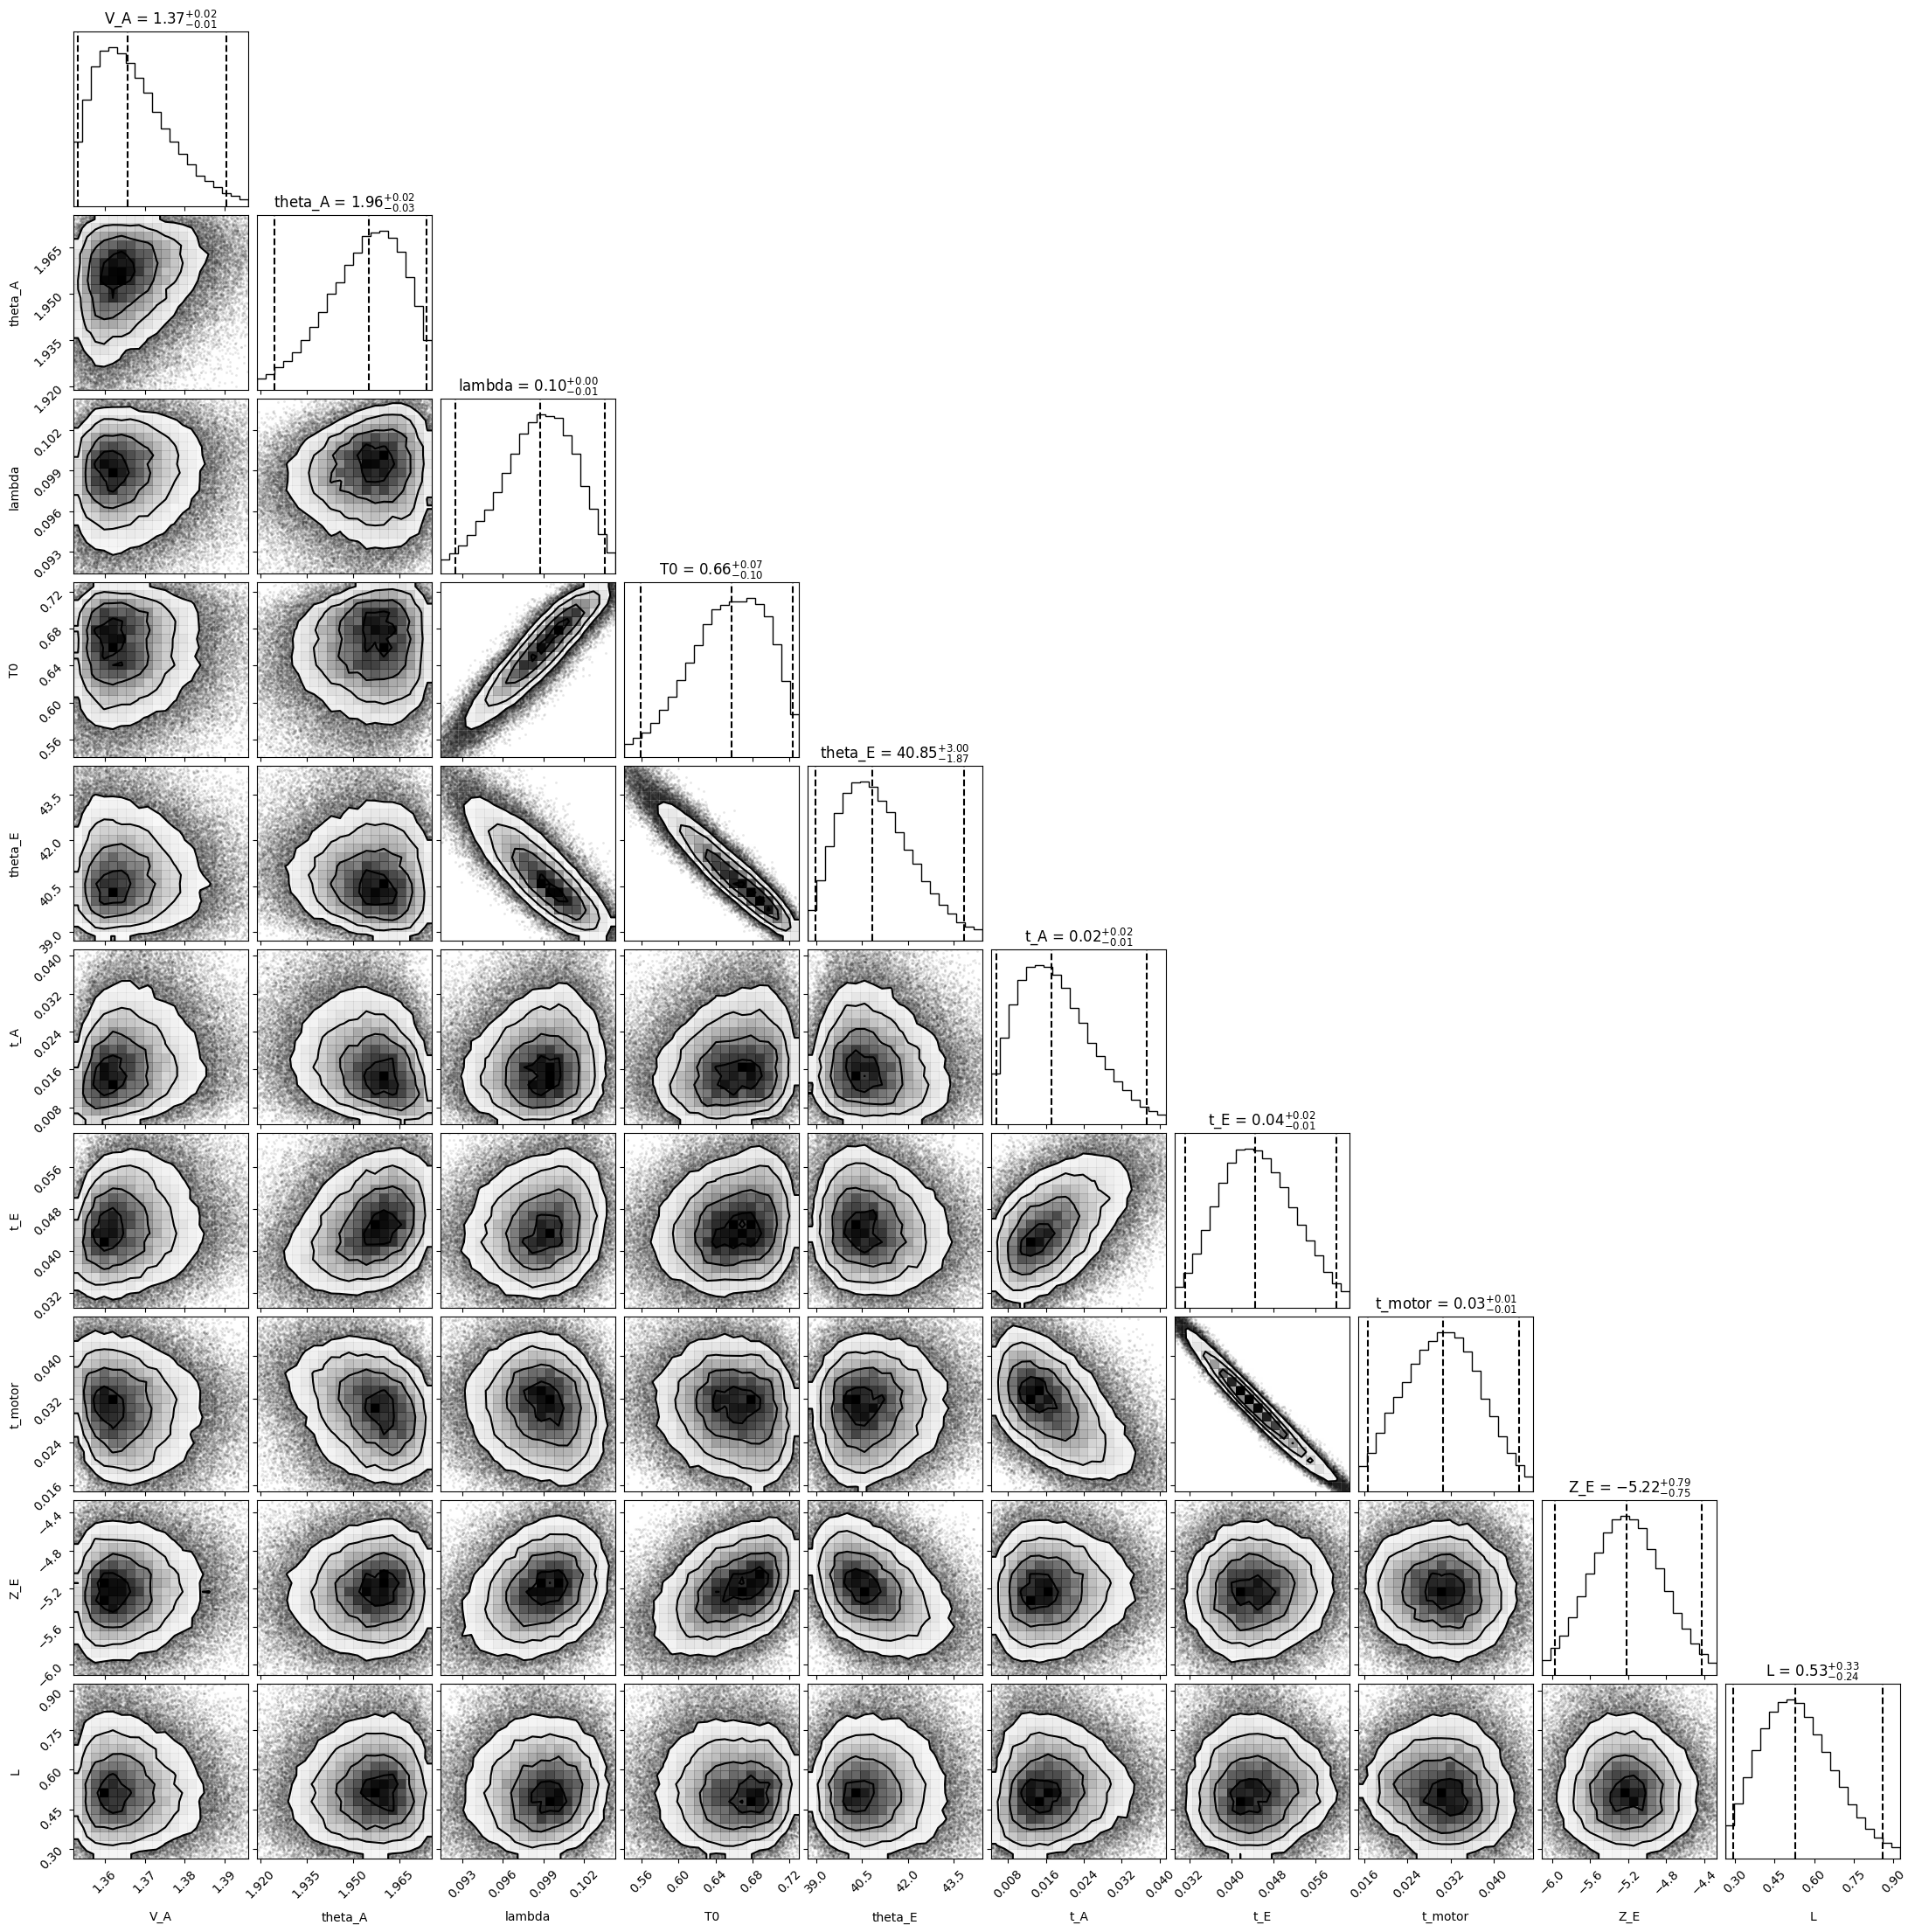

In [13]:
vp_samples = vp.sample(int(1e5))[0]

param_labels = ['V_A', 'theta_A', 'lambda', 'T0', 'theta_E', 't_A', 't_E', 't_motor', 'Z_E', 'L']

percentiles = np.percentile(vp_samples, [1, 99], axis=0)

_ranges = [(percentiles[0, i], percentiles[1, i]) for i in np.arange(vp_samples.shape[1])]


# Now create the corner plot using these ranges
corner.corner(
    vp_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
);

## mean vp param samples

In [14]:
# get mean of samples
mean_vb_params = {}
for i, label in enumerate(param_labels):
    mean_vb_params[label] = np.mean(vp_samples[:, i])

mean_vb_params['T0'] = mean_vb_params['T0'] * 1e-3 # change back to ms

## psychometric curves

In [15]:
num_RHS_dict = {}
num_trials_dict = {}
for ABL in ABL_arr:
    num_RHS_dict[ABL] = np.zeros_like(ILD_arr)
    num_trials_dict[ABL] = np.zeros_like(ILD_arr)

for idx, row in df_1.iterrows():
    ABL = row['ABL']
    ILD = row['ILD']
    if row['timed_fix'] > row['intended_fix'] and row['timed_fix'] > T_trunc: # trunc
    # if row['timed_fix'] > row['intended_fix']: # NO trunc

        num_trials_dict[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
        if row['response_poke'] == 3:
            num_RHS_dict[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1

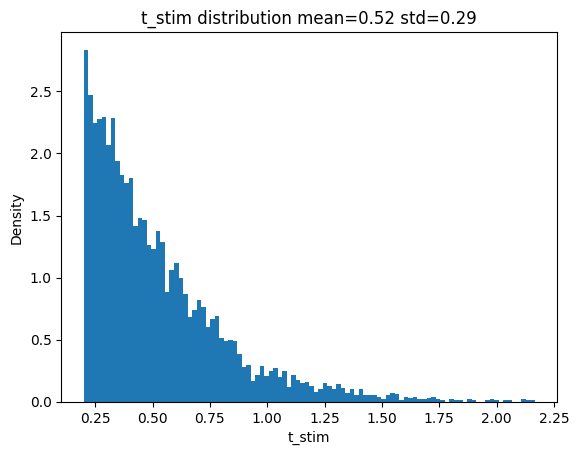

In [16]:
# get the t_stim distribution
t_stim_arr = []
for idx, row in df_1.iterrows():
    if row['response_poke'] in [2,3]:
        t_stim_arr.append(row['intended_fix'])


plt.hist(t_stim_arr, bins=100, density=True)    
plt.xlabel('t_stim')
plt.ylabel('Density')
plt.title(f't_stim distribution mean={np.mean(t_stim_arr):.2f} std={np.std(t_stim_arr):.2f}');

In [17]:
from scipy.integrate import quad
from multiprocessing import Pool

K_max = 10

N_t_stim = 100

theory_psycho_dict = {}
for ABL in ABL_arr:
    theory_psycho_dict[ABL] = np.zeros_like(ILD_arr)

for ABL in ABL_arr:
    for idx, ILD in enumerate(ILD_arr):
        # Choose 100 random t_stim from real data
        random_t_stim_set = np.random.choice(t_stim_arr, N_t_stim)

        # Define the function to compute prob_up for a given random_t_stim
        def compute_prob_up(random_t_stim):
            
            # p_up_correction = 1/(1 - quad(all_RTs_fit_single_t_fn, 0, T_trunc, args=(
            #     mean_vb_params['V_A'],
            #     mean_vb_params['theta_A'],
            #     ABL,
            #     ILD,
            #     mean_vb_params['lambda'],
            #     mean_vb_params['T0'],
            #     mean_vb_params['theta_E'],
            #     mean_vb_params['Z_E'],
            #     random_t_stim,
            #     mean_vb_params['t_A'],
            #     mean_vb_params['t_E'],
            #     mean_vb_params['t_motor'],
            #     K_max
            # ))[0])

            p_up = quad(
                up_RTs_fit_single_t_fn,
                T_trunc,
                10,
                args=(
                    mean_vb_params['V_A'],
                    mean_vb_params['theta_A'],
                    ABL,
                    ILD,
                    mean_vb_params['lambda'],
                    mean_vb_params['T0'],
                    mean_vb_params['theta_E'],
                    mean_vb_params['Z_E'],
                    random_t_stim,
                    mean_vb_params['t_A'],
                    mean_vb_params['t_E'],
                    mean_vb_params['t_motor'],
                    mean_vb_params['L'],
                    K_max
                )
            )[0] 

            p_down = quad(
                down_RTs_fit_single_t_fn,
                T_trunc,
                10,
                args=(
                    mean_vb_params['V_A'],
                    mean_vb_params['theta_A'],
                    ABL,
                    ILD,
                    mean_vb_params['lambda'],
                    mean_vb_params['T0'],
                    mean_vb_params['theta_E'],
                    mean_vb_params['Z_E'],
                    random_t_stim,
                    mean_vb_params['t_A'],
                    mean_vb_params['t_E'],
                    mean_vb_params['t_motor'],
                    mean_vb_params['L'],
                    K_max
                )
            )[0] 
            

            # p_up = p_up
            # p_down = p_down

            return p_up/(p_up + p_down)
            # return p_up
        
        

        # Use multiprocessing to compute prob_up_set in parallel
        with Pool() as pool:
            prob_up_set = pool.map(compute_prob_up, random_t_stim_set)

        # Average the probabilities
        theory_psycho_dict[ABL][idx] = np.mean(prob_up_set)


/tmp/ipykernel_3715389/2072415598.py:58: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  p_down = quad(
/tmp/ipykernel_3715389/2072415598.py:58: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator sho

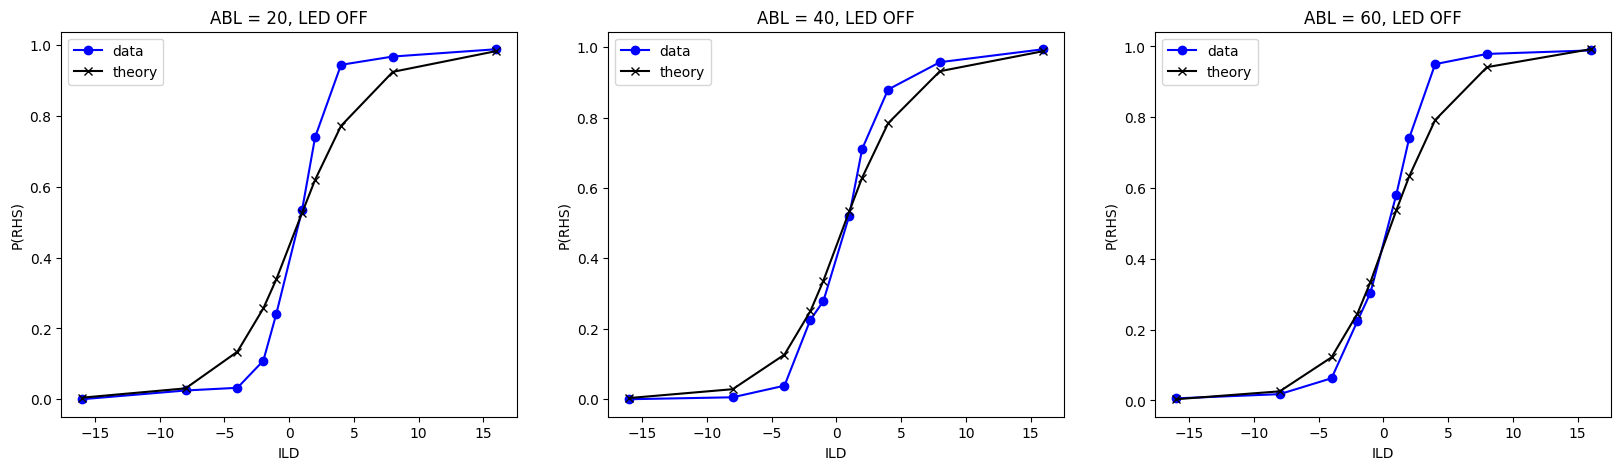

In [18]:
plt.figure(figsize=(20,5))
for i, ABL in enumerate(ABL_arr):
    plt.subplot(1, len(ABL_arr), i+1)
    plt.plot(ILD_arr, num_RHS_dict[ABL]/num_trials_dict[ABL], 'o-', label='data', color='b')
    plt.plot(ILD_arr, theory_psycho_dict[ABL], 'x-', label='theory', color='k')
    plt.title(f'ABL = {ABL}, LED OFF')
    plt.xlabel('ILD')
    plt.ylabel('P(RHS)')
    plt.legend();

# RTD quantiles for each ILD

In [19]:
data_percentile_dict = {}
percentiles = [10, 30, 50, 70, 90]


for ABL in ABL_arr:
    data_percentile_dict[ABL] = {}
    for ILD in ILD_arr:
        data_percentile_dict[ABL][ILD] = []


In [20]:
for ABL in ABL_arr:
    for ILD in ILD_arr:
        # df_1 rows with ABL and ILD
        df_1_ABL_ILD = df_1[(df_1['ABL'] == ABL) & (df_1['ILD'] == ILD) & (df_1['timed_fix'] > T_trunc)  \
                            & (df_1['response_poke'].isin([2,3]) | df_1['abort_event'].isin([3]) ) ] 
        
        # get the timed_fix
        timed_fix_arr = df_1_ABL_ILD['timed_fix']
        # get the intended_fix
        intended_fix_arr = df_1_ABL_ILD['intended_fix']

        # RT wrt to stim
        RT_stim_arr = timed_fix_arr - intended_fix_arr

        for idx, percentile in enumerate(percentiles):
            RT_stim_np_arr = np.array(RT_stim_arr)
            # remove nan
            RT_stim_np_arr = RT_stim_np_arr[~np.isnan(RT_stim_np_arr)]
            data_percentile_dict[ABL][ILD].append(np.percentile(RT_stim_np_arr, percentile))
        


## simulate data

In [21]:
t_stim_0 = 0.2
t_stim_tau = 0.4
N_print = int(1e5)
N_sim = int(1e6)
dt = 1e-4

sim_results = Parallel(n_jobs=-1)(delayed(psiam_tied_data_gen_wrapper)(
                                                                        mean_vb_params['V_A'], mean_vb_params['theta_A'], ABL_arr, ILD_arr,\
                                                                        mean_vb_params['lambda'] , mean_vb_params['T0'], mean_vb_params['theta_E'], mean_vb_params['Z_E'], \
                                                                          mean_vb_params['t_A'], mean_vb_params['t_E'], mean_vb_params['t_motor'], mean_vb_params['L'], \
                                                                        t_stim_0, t_stim_tau, iter_num, N_print, dt
                                                                        
                                                                      )

                                                                        for iter_num in range(N_sim) 
                                                                        )

In iter_num: 0, ABL: 40, ILD: -1.0, t_stim: 0.24030305731847687
In iter_num: 100000, ABL: 20, ILD: 4.0, t_stim: 0.33856271829039114
In iter_num: 200000, ABL: 60, ILD: 1.0, t_stim: 0.33278646556177516
In iter_num: 300000, ABL: 20, ILD: -8.0, t_stim: 1.4632886342866236
In iter_num: 400000, ABL: 40, ILD: 1.0, t_stim: 0.5746500305096283
In iter_num: 500000, ABL: 20, ILD: 1.0, t_stim: 0.5752042199666318
In iter_num: 600000, ABL: 60, ILD: 4.0, t_stim: 0.23330262676500885
In iter_num: 700000, ABL: 40, ILD: -4.0, t_stim: 1.2316075411507739
In iter_num: 800000, ABL: 20, ILD: 16.0, t_stim: 0.2801605898422521
In iter_num: 900000, ABL: 40, ILD: -4.0, t_stim: 0.525925730593261


In [22]:
# init dict
sim_data_ABL_ILD_RT = {}
for ABL in ABL_arr:
    sim_data_ABL_ILD_RT[ABL] = {}
    for ILD in ILD_arr:
        sim_data_ABL_ILD_RT[ABL][ILD] = []

In [23]:
for res in sim_results:
    ABL = res['ABL']
    ILD = res['ILD']
    RT = res['rt']
    t_stim = res['t_stim']

    # truncation
    if RT > T_trunc:
        sim_data_ABL_ILD_RT[ABL][ILD].append(RT - t_stim)

In [24]:
# calculate percentiles
sim_data_percentile_dict = {}

for ABL in ABL_arr:
    sim_data_percentile_dict[ABL] = {}
    for ILD in ILD_arr:
        sim_data_percentile_dict[ABL][ILD] = []


for ABL in ABL_arr:
    for ILD in ILD_arr:
        RT_stim_arr = sim_data_ABL_ILD_RT[ABL][ILD]

        for idx, percentile in enumerate(percentiles):
            RT_stim_np_arr = np.array(RT_stim_arr)
            # remove nan
            RT_stim_np_arr = RT_stim_np_arr[~np.isnan(RT_stim_np_arr)]

            sim_data_percentile_dict[ABL][ILD].append(np.percentile(RT_stim_np_arr, percentile))

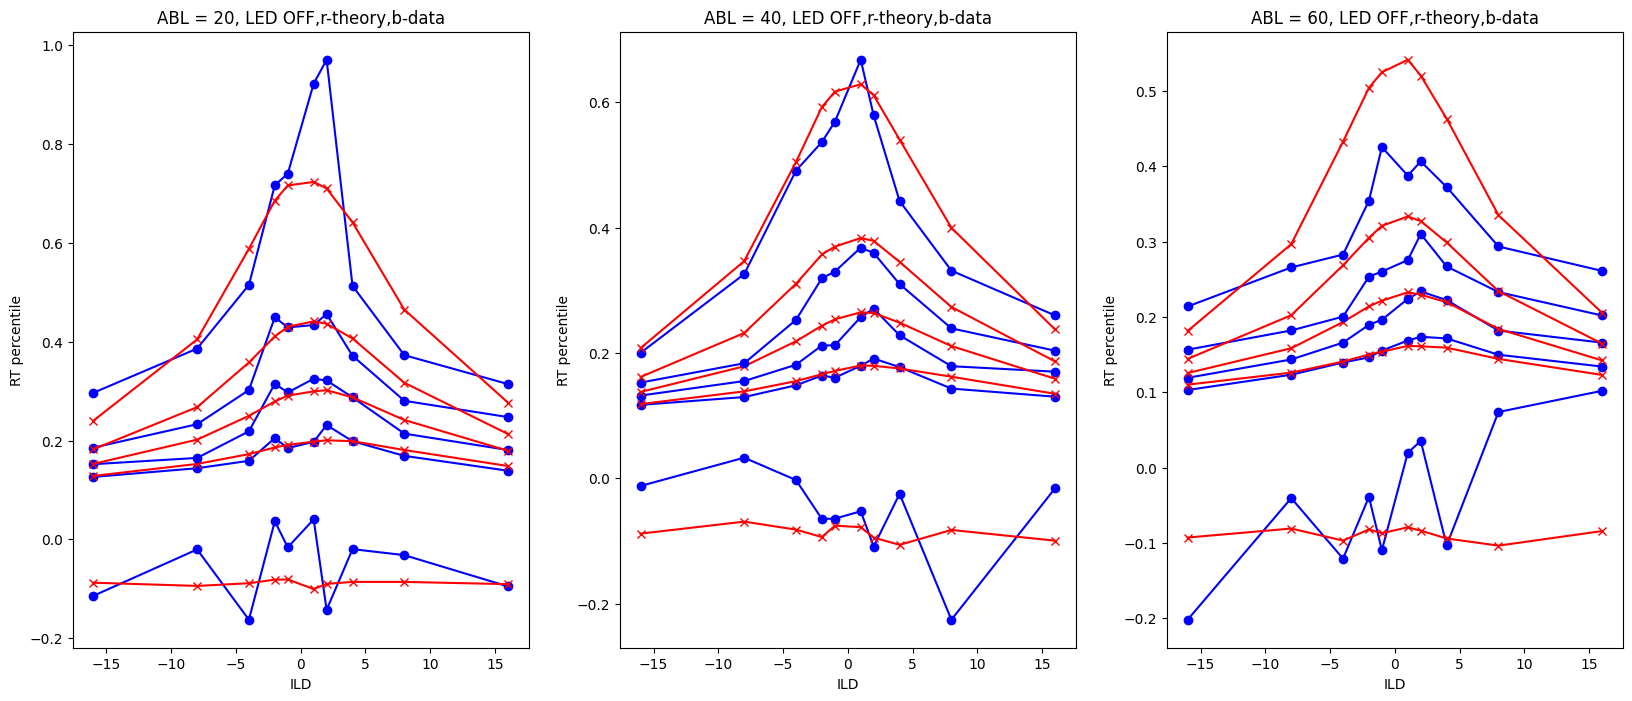

In [25]:
plt.figure(figsize=(20,8))
for i, ABL in enumerate(ABL_arr):
    plt.subplot(1, len(ABL_arr), i+1)
    for idx, percentile in enumerate(percentiles):
        plt.plot(ILD_arr, [data_percentile_dict[ABL][ILD][idx] for ILD in ILD_arr], 'o-', label=f'{percentile} percentile', color='b')
        plt.plot(ILD_arr, [sim_data_percentile_dict[ABL][ILD][idx] for ILD in ILD_arr], 'x-', label=f'{percentile} percentile', color='r')
        plt.xlabel('ILD')
        plt.ylabel('RT percentile')
        plt.title(f'ABL = {ABL}, LED OFF,r-theory,b-data')        



## compare distr of data and sim rt

fraction of aborts 272756/1000000


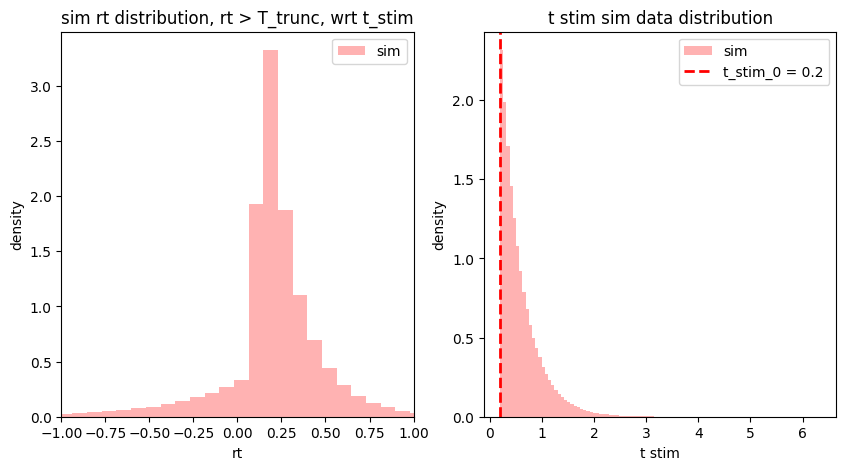

In [26]:
# sim
rt_sim = [res['rt'] - res['t_stim'] for res in sim_results if res['rt'] > T_trunc]

# frac of act
is_act = [res['is_act'] for res in sim_results]
print(f'fraction of aborts {sum(is_act)}/{N_sim}')

# data
rt_data = np.array( df_1[ ((df_1['response_poke'].isin([2,3])) | (df_1['abort_event'].isin([3]))) & ( df_1['timed_fix'] > T_trunc )]['timed_fix'] \
                   - df_1[ ((df_1['response_poke'].isin([2,3])) | (df_1['abort_event'].isin([3]))) & ( df_1['timed_fix'] > T_trunc )]['intended_fix'] )

plt.figure(figsize=(10,5))  
plt.subplot(1,2,1)
# plt.hist(rt_data, bins=100, density=True, label='data', alpha=0.3, color='b');

plt.hist(rt_sim, bins=100, density=True, label='sim', alpha=0.3, color='r');
# plt.axvline(t_stim_0, color='r', linestyle='dashed', linewidth=2, label='t_stim_0 = 0.2')
plt.title('sim rt distribution, rt > T_trunc, wrt t_stim'); plt.xlabel('rt'); plt.ylabel('density');
plt.xlim(-1, 1);
plt.legend();

plt.subplot(1,2,2)
plt.title('t stim sim data distribution')
stim_sim = [res['t_stim'] for res in sim_results]
plt.hist(stim_sim, bins=100, density=True, label='sim', alpha=0.3, color='r');
plt.xlabel('t stim'); plt.ylabel('density');plt.title('t stim sim data distribution');
plt.axvline(t_stim_0, color='r', linestyle='dashed', linewidth=2, label='t_stim_0 = 0.2')
plt.legend();

# psychometric from simulated data

In [27]:
sim_num_RHS_dict = {}
sim_num_trials_dict = {}
for ABL in ABL_arr:
    sim_num_RHS_dict[ABL] = np.zeros_like(ILD_arr)
    sim_num_trials_dict[ABL] = np.zeros_like(ILD_arr)

for res in sim_results:
    ABL = res['ABL']
    ILD = res['ILD']
    if res['rt'] > T_trunc and res['rt'] > res['t_stim']:
        sim_num_trials_dict[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
        if res['choice'] == 1:
            sim_num_RHS_dict[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1

/tmp/ipykernel_3715389/2293162724.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "x-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(ILD_arr, theory_psycho_dict[ABL], 'x-', label='theory', color='k', linestyle='dashed', lw=6)


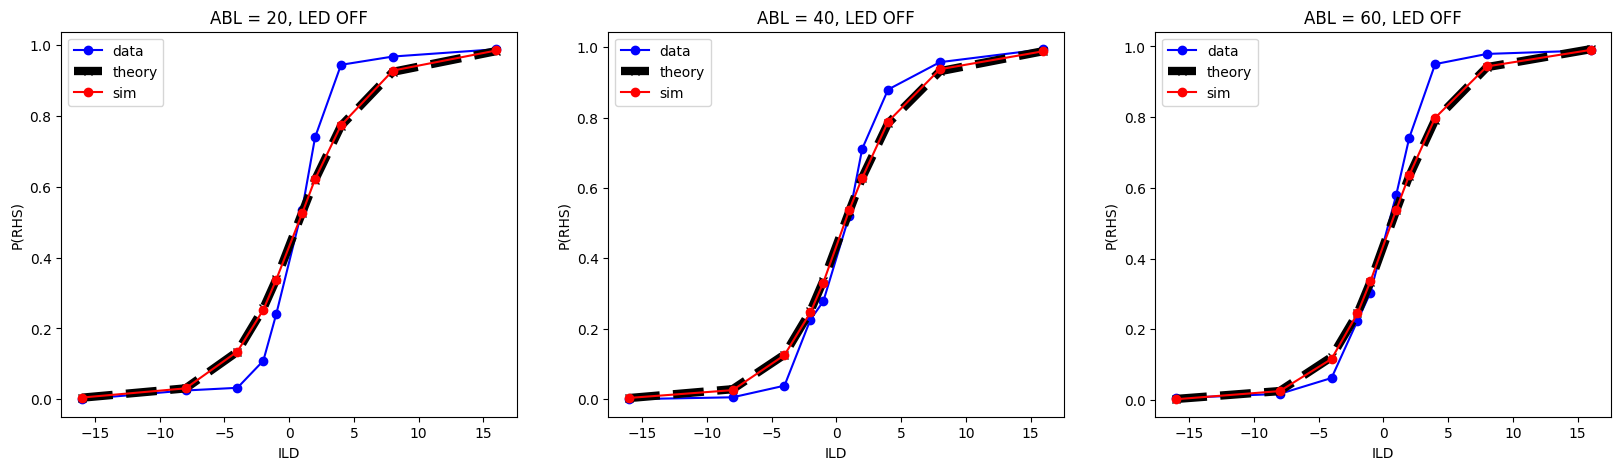

In [28]:
from matplotlib import lines


plt.figure(figsize=(20,5))
for i, ABL in enumerate(ABL_arr):
    plt.subplot(1, len(ABL_arr), i+1)
    plt.plot(ILD_arr, num_RHS_dict[ABL]/num_trials_dict[ABL], 'o-', label='data', color='b')
    plt.plot(ILD_arr, theory_psycho_dict[ABL], 'x-', label='theory', color='k', linestyle='dashed', lw=6)

    plt.plot(ILD_arr, sim_num_RHS_dict[ABL]/sim_num_trials_dict[ABL], 'o-', label='sim', color='r')
    plt.title(f'ABL = {ABL}, LED OFF')
    plt.xlabel('ILD')
    plt.ylabel('P(RHS)')
    plt.legend();

# tachometric - prob up vs Time

In [29]:
t_bin_width = 0.05
t_pts = np.arange(0, 5, t_bin_width)

data_all_trials = {}
data_up_trials = {}

sim_all_trials = {}
sim_up_trials = {}

for ABL in ABL_arr:
    for ILD in ILD_arr:
        data_all_trials[(ABL, ILD)] = np.zeros_like(t_pts)
        data_up_trials[(ABL, ILD)] = np.zeros_like(t_pts)

        sim_all_trials[(ABL, ILD)] = np.zeros_like(t_pts)
        sim_up_trials[(ABL, ILD)] = np.zeros_like(t_pts)

# data
for idx, row in df_1.iterrows():
    ABL = row['ABL']
    ILD = row['ILD']
    if row['timed_fix'] > T_trunc and row['timed_fix'] > row['intended_fix']: # truncated and non aborts
        t_idx = int((row['timed_fix']-row['intended_fix']) // t_bin_width)
        data_all_trials[(ABL, ILD)][t_idx] += 1

        if row['response_poke'] == 3:
            data_up_trials[(ABL, ILD)][t_idx] += 1

# sim
for res in sim_results:
    ABL = res['ABL']
    ILD = res['ILD']
    if res['rt'] > T_trunc and res['rt'] > res['t_stim']:
        t_idx = int((res['rt'] - res['t_stim']) // t_bin_width)
        sim_all_trials[(ABL, ILD)][t_idx] += 1

        if res['choice'] == 1:
            sim_up_trials[(ABL, ILD)][t_idx] += 1


/tmp/ipykernel_3715389/3891270480.py:6: RuntimeWarning: invalid value encountered in divide
  plt.plot(t_pts, data_up_trials[(ABL, ILD)]/data_all_trials[(ABL, ILD)], 'o-', label=f'data', color='b')
/tmp/ipykernel_3715389/3891270480.py:7: RuntimeWarning: invalid value encountered in divide
  plt.plot(t_pts, sim_up_trials[(ABL, ILD)]/sim_all_trials[(ABL, ILD)], 'x-', label=f'sim', color='r')


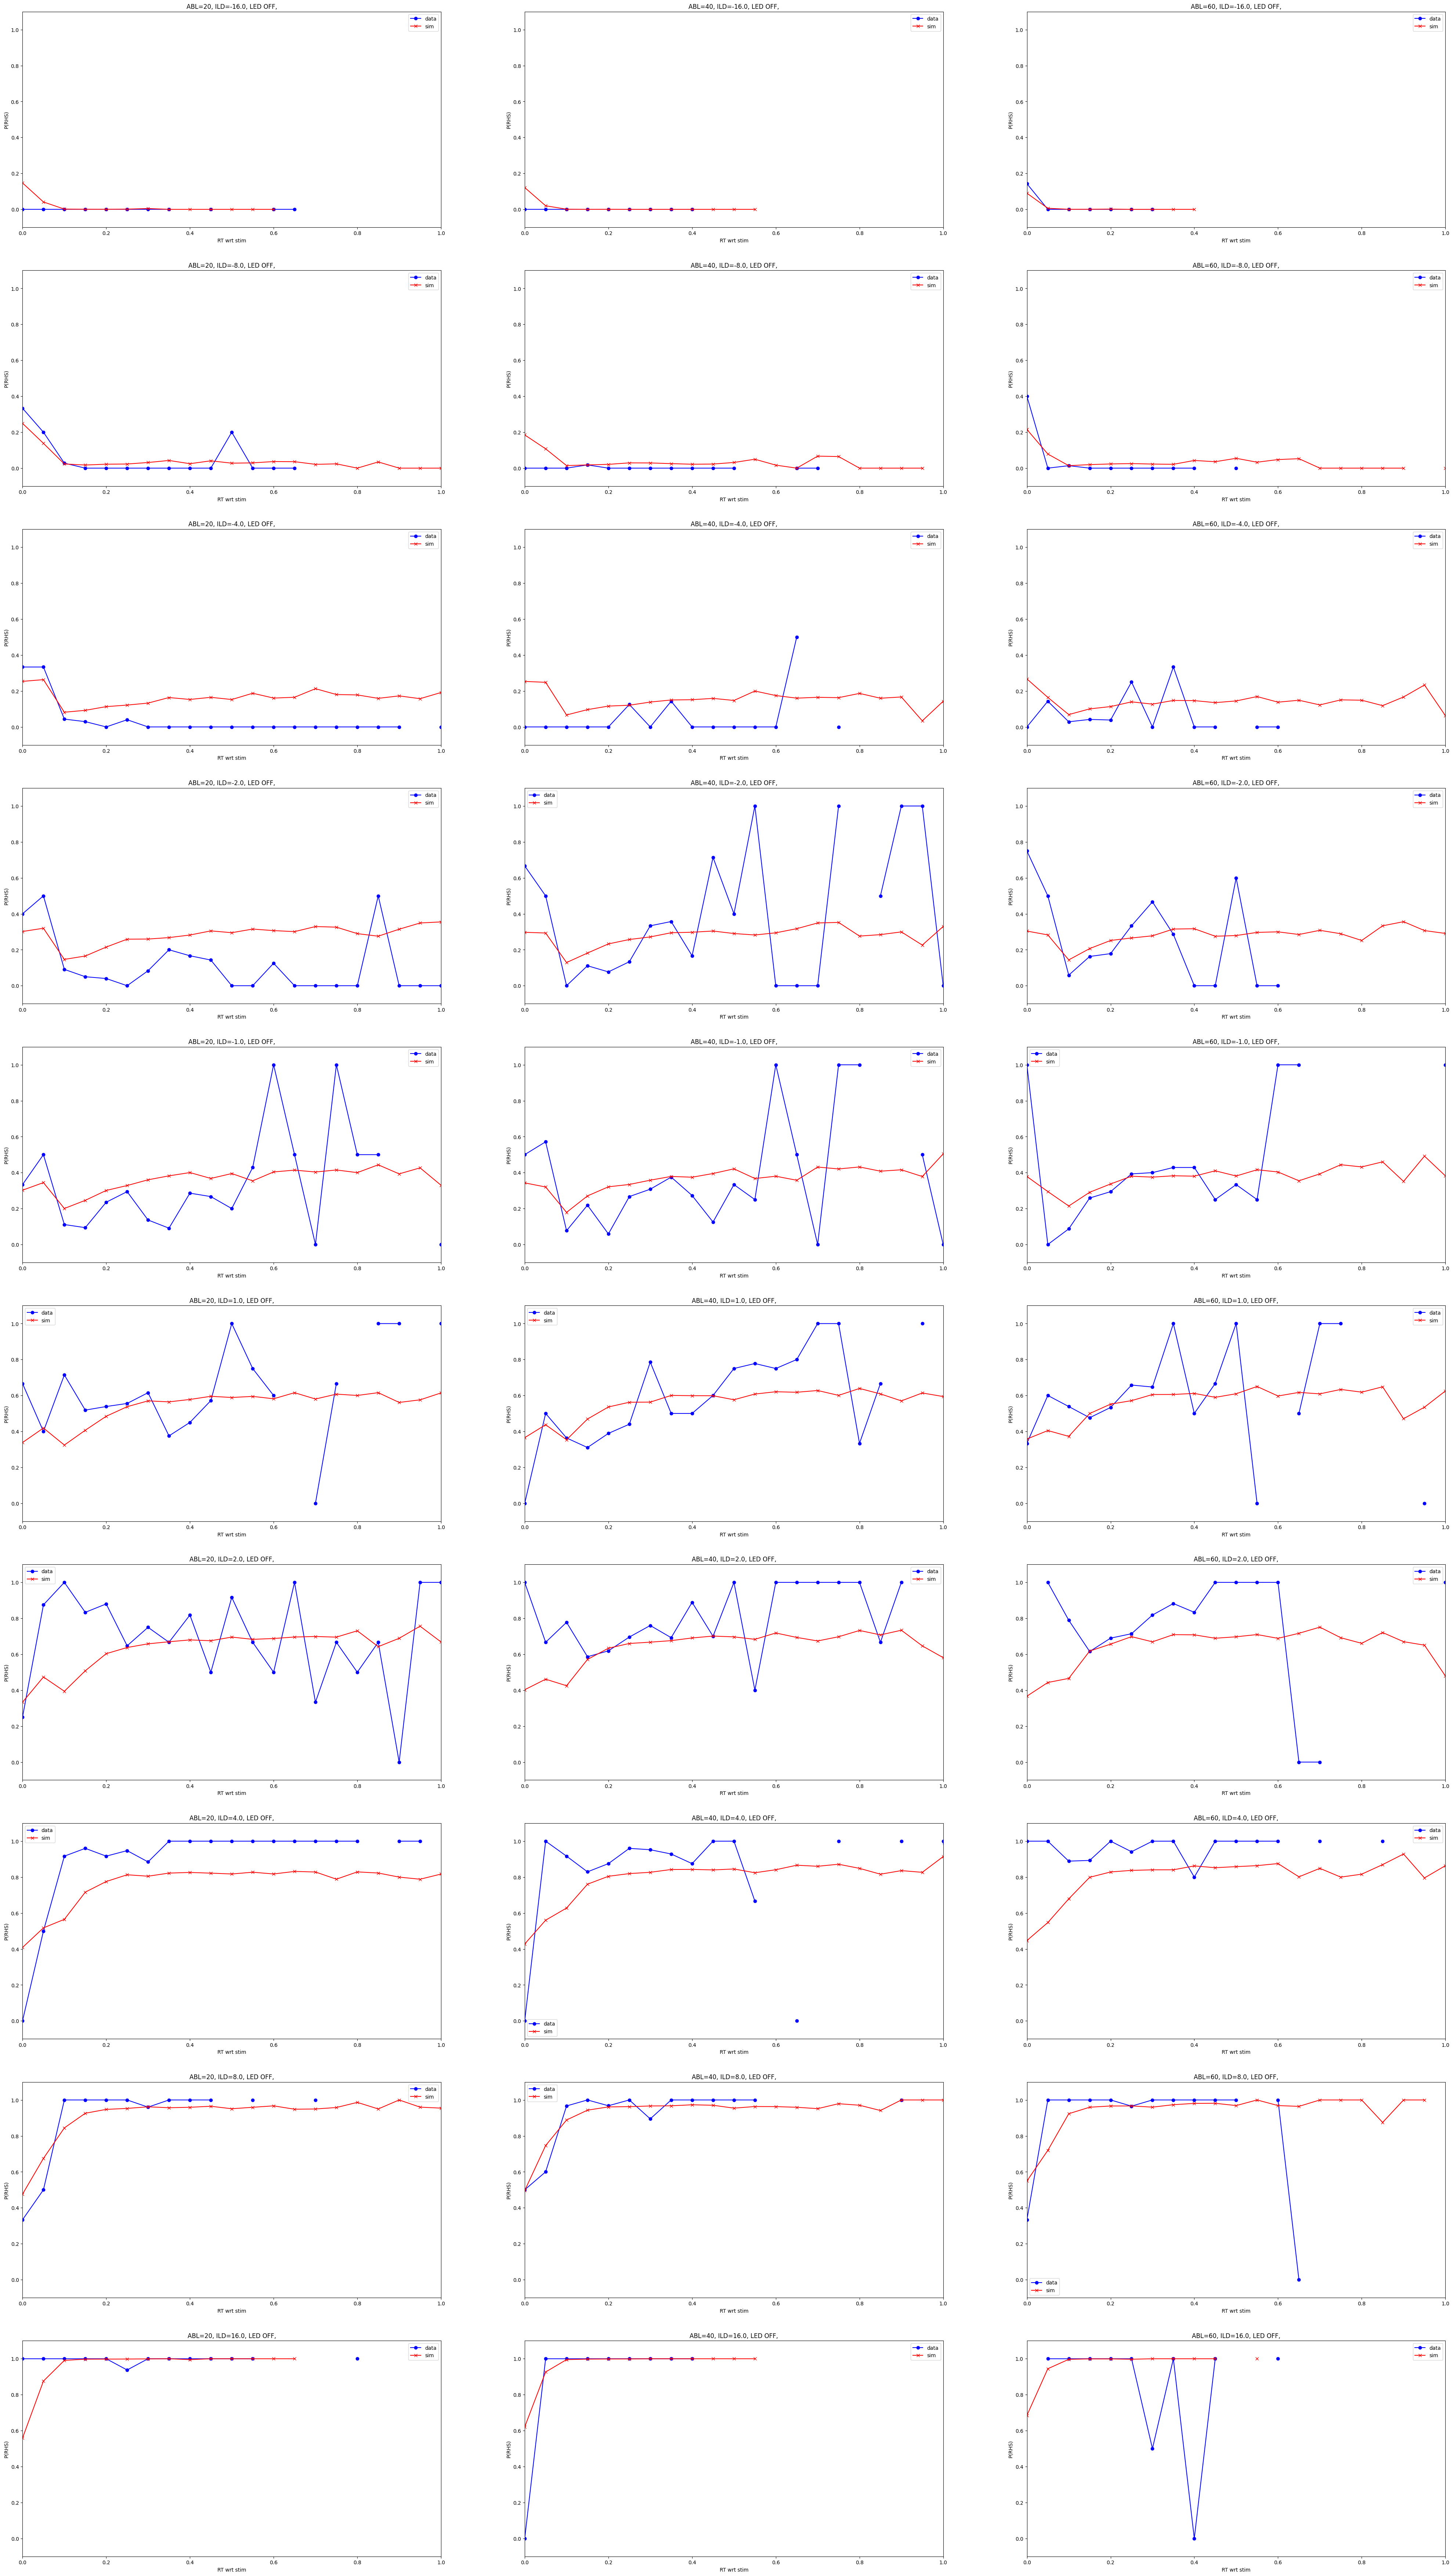

In [30]:
plt.figure(figsize=(50,90))
f = 1
for ILD in ILD_arr:
    for ABL in ABL_arr:
        plt.subplot(len(ILD_arr), len(ABL_arr), f)
        plt.plot(t_pts, data_up_trials[(ABL, ILD)]/data_all_trials[(ABL, ILD)], 'o-', label=f'data', color='b')
        plt.plot(t_pts, sim_up_trials[(ABL, ILD)]/sim_all_trials[(ABL, ILD)], 'x-', label=f'sim', color='r')
        plt.title(f'ABL={ABL}, ILD={ILD}, LED OFF,')
        plt.xlabel('RT wrt stim')
        plt.ylabel('P(RHS)')
        plt.xlim(0, 1)
        plt.legend();
        plt.ylim(-0.1, 1.1);
        f += 1
    
    

## tachometric, all ABL in one

/tmp/ipykernel_3715389/4111708508.py:22: RuntimeWarning: invalid value encountered in divide
  plt.plot(t_pts, data_up_trials_all_ILD/data_all_trials_all_ILD, 'o-', label=f'data', color='b')
/tmp/ipykernel_3715389/4111708508.py:23: RuntimeWarning: invalid value encountered in divide
  plt.plot(t_pts, sim_up_trials_all_ILD/sim_all_trials_all_ILD, 'x-', label=f'sim', color='r')


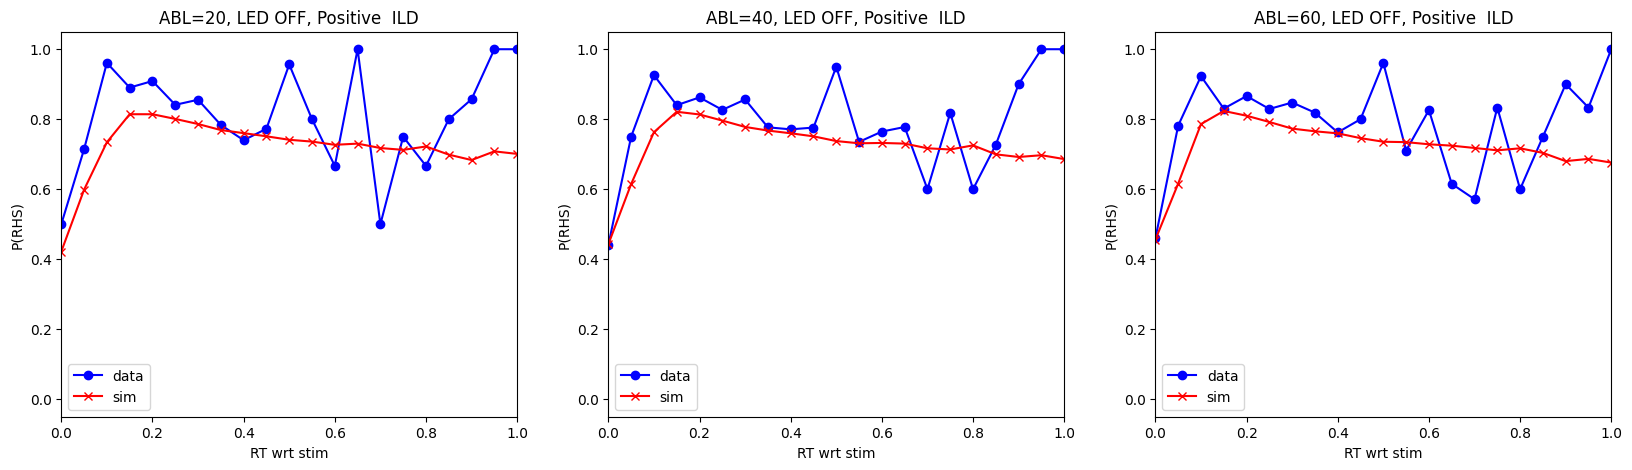

In [31]:
data_all_trials_all_ILD = np.zeros_like(t_pts)
data_up_trials_all_ILD = np.zeros_like(t_pts)

sim_all_trials_all_ILD = np.zeros_like(t_pts)
sim_up_trials_all_ILD = np.zeros_like(t_pts)


positive_ILDs = ILD_arr[ILD_arr > 0]
negative_ILDs = ILD_arr[ILD_arr < 0]

plt.figure(figsize=(20,5))
f = 1
for a, ABL in enumerate(ABL_arr):
    plt.subplot(1, len(ABL_arr), f)
    for ILD in positive_ILDs:
        data_all_trials_all_ILD += data_all_trials[(ABL, ILD)]
        data_up_trials_all_ILD += data_up_trials[(ABL, ILD)]

        sim_all_trials_all_ILD += sim_all_trials[(ABL, ILD)]
        sim_up_trials_all_ILD += sim_up_trials[(ABL, ILD)]
    
    plt.plot(t_pts, data_up_trials_all_ILD/data_all_trials_all_ILD, 'o-', label=f'data', color='b')
    plt.plot(t_pts, sim_up_trials_all_ILD/sim_all_trials_all_ILD, 'x-', label=f'sim', color='r')

    plt.title(f'ABL={ABL}, LED OFF, Positive  ILD')
    plt.xlabel('RT wrt stim')
    plt.ylabel('P(RHS)')
    plt.xlim(0, 1)
    plt.legend();

    f += 1
    
    



/tmp/ipykernel_3715389/1464632565.py:18: RuntimeWarning: invalid value encountered in divide
  plt.plot(t_pts, data_up_trials_all_ILD/data_all_trials_all_ILD, 'o-', label=f'data', color='b')
/tmp/ipykernel_3715389/1464632565.py:19: RuntimeWarning: invalid value encountered in divide
  plt.plot(t_pts, sim_up_trials_all_ILD/sim_all_trials_all_ILD, 'x-', label=f'sim', color='r')


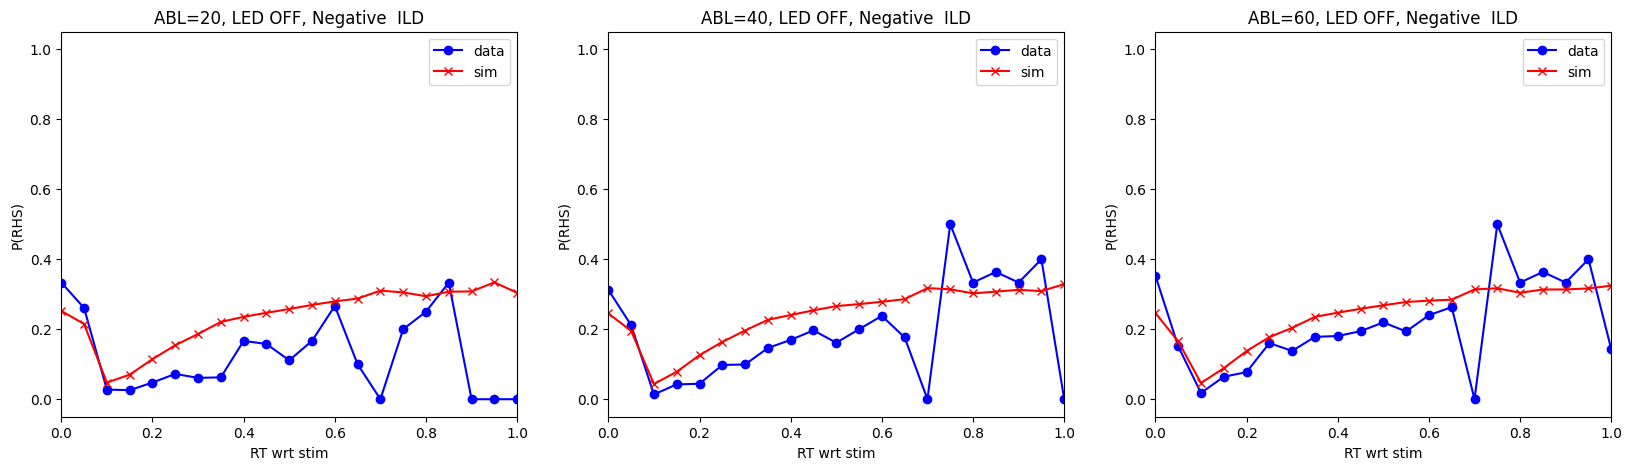

In [32]:
data_all_trials_all_ILD = np.zeros_like(t_pts)
data_up_trials_all_ILD = np.zeros_like(t_pts)

sim_all_trials_all_ILD = np.zeros_like(t_pts)
sim_up_trials_all_ILD = np.zeros_like(t_pts)

plt.figure(figsize=(20,5))
f = 1
for a, ABL in enumerate(ABL_arr):
    plt.subplot(1, len(ABL_arr), f)
    for ILD in negative_ILDs:
        data_all_trials_all_ILD += data_all_trials[(ABL, ILD)]
        data_up_trials_all_ILD += data_up_trials[(ABL, ILD)]

        sim_all_trials_all_ILD += sim_all_trials[(ABL, ILD)]
        sim_up_trials_all_ILD += sim_up_trials[(ABL, ILD)]
    
    plt.plot(t_pts, data_up_trials_all_ILD/data_all_trials_all_ILD, 'o-', label=f'data', color='b')
    plt.plot(t_pts, sim_up_trials_all_ILD/sim_all_trials_all_ILD, 'x-', label=f'sim', color='r')

    plt.title(f'ABL={ABL}, LED OFF, Negative  ILD')
    plt.xlabel('RT wrt stim')
    plt.ylabel('P(RHS)')
    plt.xlim(0, 1)
    plt.legend();

    f += 1


(np.float64(0.200132111776733), np.float64(2.19771393622595))

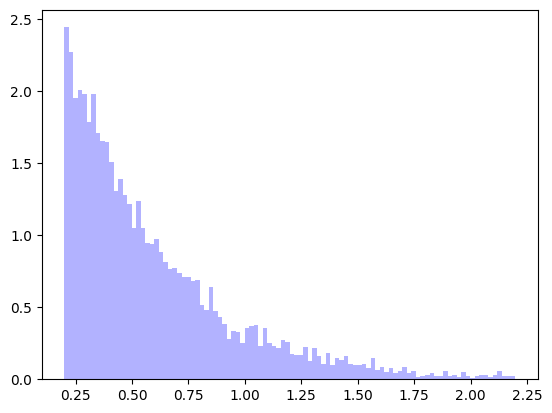

In [34]:
plt.hist(df_1['intended_fix'], bins=100, density=True, label='data', alpha=0.3, color='b');
np.min(df_1['intended_fix']), np.max(df_1['intended_fix'])